* Master DAC, BDLE, 2021 
* Author: Mohamed-Amine Baazizi
* Affiliation: LIP6 - Faculté des Sciences - Sorbonne Université
* Email: mohamed-amine.baazizi@lip6.fr


Binome : Sihamdi Mostefa,Bousba Abdellah

# Decision Tree in Spark ML



```
# This is formatted as code
```

## Préparation

Vérifier que des ressources de calcul sont allouées à votre notebook est connecté (cf RAM  de disque indiqués en haut à droite) . Sinon cliquer sur le bouton connecter pour obtenir des ressources.




Pour accéder directement aux fichiers stockées sur votre google drive. Renseigner le code d'authentification lorsqu'il est demandé

Ajuster le nom de votre dossier : MyDrive/ens/bdle/dir. **Remplacer dir **

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

drive_dir = "/content/drive/MyDrive/ens/bdle/dir"
os.makedirs(drive_dir, exist_ok=True)
os.listdir(drive_dir)

Mounted at /content/drive


[]

Installer pyspark et findspark :


In [ ]:
!pip install -q pyspark
!pip install -q findspark

     |████████████████████████████████| 281.3 MB 38 kB/s 
     |████████████████████████████████| 198 kB 35.0 MB/s 


Démarrer la session spark

In [ ]:
import os
# !find /usr/local -name "pyspark"
os.environ["SPARK_HOME"] = "/usr/local/lib/python3.7/dist-packages/pyspark"
os.environ["JAVA_HOME"] = "/usr"

In [ ]:
# Principaux import
import findspark
from pyspark.sql import SparkSession 
from pyspark import SparkConf  

# pour les dataframe et udf
from pyspark.sql import *  
from pyspark.sql.functions import *
from pyspark.sql.types import *
from datetime import *

# pour le chronomètre
import time

# initialise les variables d'environnement pour spark
findspark.init()

# Démarrage session spark 
# --------------------------
def demarrer_spark():
  local = "local[*]"
  appName = "TP"
  configLocale = SparkConf().setAppName(appName).setMaster(local).\
  set("spark.executor.memory", "6G").\
  set("spark.driver.memory","6G").\
  set("spark.sql.catalogImplementation","in-memory")
  
  spark = SparkSession.builder.config(conf = configLocale).getOrCreate()
  sc = spark.sparkContext
  sc.setLogLevel("ERROR")
  
  spark.conf.set("spark.sql.autoBroadcastJoinThreshold","-1")

  # On ajuste l'environnement d'exécution des requêtes à la taille du cluster (4 coeurs)
  spark.conf.set("spark.sql.shuffle.partitions","4")    
  print("session démarrée, son id est ", sc.applicationId)
  return spark
spark = demarrer_spark()

session démarrée, son id est  local-1636466904345


In [ ]:
# on utilise 8 partitions au lieu de 200 par défaut
spark.conf.set("spark.sql.shuffle.partitions", "8")
print("Nombre de partitions utilisées : ", spark.conf.get("spark.sql.shuffle.partitions"))

Nombre de partitions utilisées :  8


## Data loading

In [ ]:
data = [["young","high","no","fair","no"],
        ["young","high","no","excellent","no"],
        ["middle","high","no","fair","yes"],
        ["senior","medium","no","fair","yes"],
        ["senior","low","yes","fair","yes"],
        ["senior","low","yes","excellent","no"],
        ["middle","low","yes","excellent","yes"],
        ["young","medium","no","fair","no"],
        ["young","low","yes","fair","yes"],
        ["senior","medium","yes","fair","yes"],
        ["young","medium","yes","excellent","yes"],
        ["middle","medium","no","excellent","yes"],
        ["middle","high","yes","fair","yes"],
        ["senior","medium","no","excellent","no"]]
    

In [ ]:
df = spark.createDataFrame(spark.sparkContext.parallelize(data),'age String, income String, student String, rating String, label String')

In [ ]:
df.printSchema()
df.show()

root
 |-- age: string (nullable = true)
 |-- income: string (nullable = true)
 |-- student: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- label: string (nullable = true)

+------+------+-------+---------+-----+
|   age|income|student|   rating|label|
+------+------+-------+---------+-----+
| young|  high|     no|     fair|   no|
| young|  high|     no|excellent|   no|
|middle|  high|     no|     fair|  yes|
|senior|medium|     no|     fair|  yes|
|senior|   low|    yes|     fair|  yes|
|senior|   low|    yes|excellent|   no|
|middle|   low|    yes|excellent|  yes|
| young|medium|     no|     fair|   no|
| young|   low|    yes|     fair|  yes|
|senior|medium|    yes|     fair|  yes|
| young|medium|    yes|excellent|  yes|
|middle|medium|     no|excellent|  yes|
|middle|  high|    yes|     fair|  yes|
|senior|medium|     no|excellent|   no|
+------+------+-------+---------+-----+



In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler



from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ['age', 'income', 'student', 'rating']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'label', outputCol = 'label_index')
stages += [label_stringIdx]

assemblerInputs = [c + "classVec" for c in categoricalColumns]
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]


from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label_index', 'features']
df = df.select(selectedCols)
df.printSchema()

root
 |-- label_index: double (nullable = false)
 |-- features: vector (nullable = true)



In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 11
Test Dataset Count: 3


In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label_index', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('label_index', 'rawPrediction', 'prediction', 'probability').show(10)

+-----------+-------------+----------+-----------+
|label_index|rawPrediction|prediction|probability|
+-----------+-------------+----------+-----------+
|        0.0|    [1.0,0.0]|       0.0|  [1.0,0.0]|
|        0.0|    [1.0,0.0]|       0.0|  [1.0,0.0]|
|        0.0|    [4.0,0.0]|       0.0|  [1.0,0.0]|
+-----------+-------------+----------+-----------+



# TEST sur les données de AIRBNB (Regréssion)

On a trouvé les données dans http://insideairbnb.com/get-the-data.html, la source des données est le site airbnb,Nous avons choisi le dataset de Paris qui represente les prix de loyer d'un appratement par nuit 

Le dataset contient 16 attributs dont la variable à prédire est le prix

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-rbnb').getOrCreate()
df = spark.read.csv('listings.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: string (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: string (nullable = true)
 |-- availability_365: string (nullable = true)
 |-- number_of_reviews_ltm: string (nullable = true)
 |-- license: string (nullable = true)



Affichage de notre base de données

In [ ]:
df.show()

+-----+--------------------+---------+----------+-------------------+-------------------+---------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+
|   id|                name|  host_id| host_name|neighbourhood_group|      neighbourhood| latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|             license|
+-----+--------------------+---------+----------+-------------------+-------------------+---------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+
| 5396|Explore the heart...|     7903|    Borzou|               null|     Hôtel-de-Ville| 48.85247|  2.35835|Entire home/apt|  110|           

Nous remarquons que notre jeu de données est un peu bruité, nous allons essayer de faire un nettoyage de notre base de données, nous commençons par déterminer le type réel de tous les attributs de notre base de données.

In [ ]:
from pyspark.sql.types import * 
df = df.withColumn("id",df["id"].cast(IntegerType()))\
.withColumn("name",df["name"].cast(StringType()))\
.withColumn("host_id",df["host_id"].cast(IntegerType()))\
.withColumn("host_name",df["host_name"].cast(StringType()))\
.withColumn("neighbourhood_group",df["neighbourhood_group"].cast(StringType()))\
.withColumn("neighbourhood",df["neighbourhood"].cast(StringType()))\
.withColumn("latitude",df["latitude"].cast(DoubleType()))\
.withColumn("longitude",df["longitude"].cast(DoubleType()))\
.withColumn("room_type",df["room_type"].cast(StringType()))\
.withColumn("price",df["price"].cast(IntegerType()))\
.withColumn("minimum_nights",df["minimum_nights"].cast(IntegerType()))\
.withColumn("number_of_reviews",df["number_of_reviews"].cast(IntegerType()))\
.withColumn("last_review",df["last_review"].cast(StringType()))\
.withColumn("reviews_per_month",df["reviews_per_month"].cast(DoubleType()))\
.withColumn("calculated_host_listings_count",df["calculated_host_listings_count"].cast(IntegerType()))\
.withColumn("availability_365",df["availability_365"].cast(IntegerType()))\
.withColumn("number_of_reviews_ltm",df["number_of_reviews_ltm"].cast(IntegerType()))\
.withColumn("license",df["license"].cast(StringType()))


In [ ]:
df.printSchema()
df.show()

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: integer (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- calculated_host_listings_count: integer (nullable = true)
 |-- availability_365: integer (nullable = true)
 |-- number_of_reviews_ltm: integer (nullable = true)
 |-- license: string (nullable = true)

+-----+--------------------+---------+----------+-------------------+-------------------+---------+---------+---------------+-----+--------------+-----------------+-----------+----------------

maintenant on va calculer la taille de notre base de données

In [ ]:
df.count()

50236

on remarque que notre dataset contient assez de données pour faire l'entrainement

Maintenant nous allons compter le nombre de valeurs manquantes pour chaque colonne

In [ ]:
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+-------+
| id|name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|license|
+---+----+-------+---------+-------------------+-------------+--------+---------+---------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+-------+
|103|  53|    216|      231|              50123|          118|     122|      203|      106|  120|           107|              198|      11524|            11515|                           109|             105|                  199|  22397|
+---+----+-------+---------+----------------

In [ ]:
df.show()

+-----+--------------------+---------+----------+-------------------+-------------------+---------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+
|   id|                name|  host_id| host_name|neighbourhood_group|      neighbourhood| latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|             license|
+-----+--------------------+---------+----------+-------------------+-------------------+---------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+
| 5396|Explore the heart...|     7903|    Borzou|               null|     Hôtel-de-Ville| 48.85247|  2.35835|Entire home/apt|  110|           


Nous allons effectuer les opérations suivantes: 


* supprimer les colonnes: id et name(car non discriminant)
* supprimer host_name et host_id (non discriminant)
* supprimer la colonne neighbourhood_group (car nulle pour toutes les valeurs)
* supprimer la colonne last_reviews (pas utile pour la prédiction)
* supprimer la colonne licence (pas utile pour la prédiction)

et supprimer les valeurs nulls

donc on va travailler avec les colonnes suivant : neighbourhood, latitude, longitude, room_type, price, number_of_reviews, reviews_per_month,availability_365, number_of_reviews_ltm












In [ ]:
my_col = df.select(['neighbourhood','latitude','longitude','room_type','price','number_of_reviews','reviews_per_month','availability_365',"number_of_reviews_ltm"]).withColumnRenamed("price", "label")
df = my_col.na.drop()
df.printSchema()
df.show()

root
 |-- neighbourhood: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- number_of_reviews: integer (nullable = true)
 |-- reviews_per_month: double (nullable = true)
 |-- availability_365: integer (nullable = true)
 |-- number_of_reviews_ltm: integer (nullable = true)

+-------------------+---------+---------+---------------+-----+-----------------+-----------------+----------------+---------------------+
|      neighbourhood| latitude|longitude|      room_type|label|number_of_reviews|reviews_per_month|availability_365|number_of_reviews_ltm|
+-------------------+---------+---------+---------------+-----+-----------------+-----------------+----------------+---------------------+
|     Hôtel-de-Ville| 48.85247|  2.35835|Entire home/apt|  110|              260|             2.68|              29|                   35|
|     Hôtel-de-Ville| 48.85909|

maintenant nous allons essayer de trouver les paramètres numériques et catégoriels. 

In [ ]:
numericCols = [t[0] for t in df.dtypes if (t[1] == 'int' or t[1]=='double')and t[0]!="label"]
df.select(numericCols).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
latitude,38622,48.86388445158622,0.018096428439333408,48.81308,48.90568
longitude,38622,2.346037704964083,0.03262762995013811,2.22387,2.46705
number_of_reviews,38622,26.99984464812801,49.55221617479641,1,1596
reviews_per_month,38622,0.7916811661747465,1.2085802267828902,0.01,48.91
availability_365,38622,101.03047485888871,133.72070589664648,0,365
number_of_reviews_ltm,38622,3.2622598518978823,13.060790806515048,0,1578


In [ ]:
categoricalColumns = [t[0] for t in df.dtypes if t[1] == 'string']
df.select(categoricalColumns).describe().toPandas().transpose()

df1=df

Encodage des features: indexation des string,assemblage des vecteurs puis indexation.au premier on va essayer de travailler just avec stringIndexer sans utiliser OneHotEncoder

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

string_indexer=StringIndexer(inputCols=categoricalColumns,outputCols=[c+"index" for c in categoricalColumns])
assemblerInputs = [c + "index" for c in categoricalColumns] + numericCols
vecassem = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages=[]
stages+=[string_indexer]
stages+=[vecassem]

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features']
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



Construcition d'une paire 30%-70% de jeux de test et d'entrainement

In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 27069
Test Dataset Count: 11553


aprés la construction des données train et test,maintenant on va entrainer une arbre de decsion (DecisionTreeRegressor)

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol="features",labelCol="label")
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.show()

+-----+--------------------+------------------+
|label|            features|        prediction|
+-----+--------------------+------------------+
|    0|[3.0,2.0,48.84951...|103.07090719499479|
|   10|[4.0,3.0,48.88648...| 50.01670644391408|
|   10|[6.0,3.0,48.8908,...| 40.85353535353536|
|   10|[13.0,0.0,48.8240...|162.06593406593407|
|   10|[15.0,0.0,48.8605...|120.01903511650804|
|   11|(8,[2,3,4,5],[48....| 78.88369364839953|
|   15|(8,[2,3,4,5],[48....| 78.88369364839953|
|   15|[4.0,1.0,48.89351...| 50.01670644391408|
|   15|[13.0,1.0,48.8280...| 50.01670644391408|
|   15|[14.0,3.0,48.8414...|60.057377049180324|
|   16|[5.0,1.0,48.87419...| 40.85353535353536|
|   17|[0.0,3.0,48.88477...| 50.01670644391408|
|   17|[18.0,1.0,48.8474...| 204.9568773234201|
|   18|[0.0,1.0,48.88597...| 50.01670644391408|
|   18|[1.0,3.0,48.86692...|125.43570843570843|
|   19|[5.0,0.0,48.86522...| 78.88369364839953|
|   19|[6.0,1.0,48.87581...| 40.85353535353536|
|   19|[11.0,1.0,48.8210...| 47.62105263

aprés on va evaluer notre modéls en calculant le rmse et mae

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE= %g" % rmse)

RMSE= 187.764


In [ ]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print("MAE = %g" % mae)

MAE = 60.8413


Nous obtenons un taux d'erreur RMSE égale à 187.764 et un taux d'erreur MAE de 60.8413

Vu que le RMSE prend la moyenne des erreurs au carré, il donne un poids fort aux larges erreurs, par conséquant RMSE peut etre utilisé pour pénaliser les grosses erreurs

---



Nous essayons maintenant de trouver les paramètres optimaux et le meilleur modèle en utilisant la cross validation. 

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

dt = DecisionTreeRegressor(featuresCol="features",labelCol="label")

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2,3,4,5,6,7,8,9,10,11,12,13])
             .addGrid(dt.maxBins, [20,30,40,50,70])
             .addGrid(dt.minInstancesPerNode, [1, 2, 3, 5, 7])
             .build())

cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)

In [ ]:
bestModel = cvModel.bestModel
predictions = bestModel.transform(test)

In [ ]:
bestModel

DecisionTreeRegressionModel: uid=DecisionTreeRegressor_b4e726417d74, depth=5, numNodes=63, numFeatures=8

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE = %g" % rmse)

RMSE = 187.055


Nous obtenons un taux d'erreur RMSE égale à 187.055

nous trouvons les paramétres optimal suivant :  depth=5, numNodes=63, numFeatures=8,Nous remarquons que l'utilisation de la validation croisée pour sélectionner les paramètres optimal a bien amélioré les performances de notre modèle.

## Amélioration de notre modéle

Nous avons testé un arbre de décision avec notre jeu de données sans faire aucun prétraitement (sauf supprimer les nuls et supprimer les attributs inutiles), maintenant nous allons essayer de voir la relation entre chaque attribut et le prix, et faire les transformations nécessaires,normaliser les données et réduire la dimension en utilisant PCA. 

On va voir les attributs non pertinents (attributs avec nombre élevé de valeurs distinctes ou qui ne varient jamais),aussi on va essayer de voir la relation entre chaque attributs et notre target (prix)

L'attibut Prix

In [ ]:
df=df1

In [ ]:
from pyspark.sql.functions import desc

df.select("label").groupby("label").count().orderBy(desc("count")).show()

+-----+-----+
|label|count|
+-----+-----+
|   60| 1609|
|   80| 1587|
|   70| 1523|
|   50| 1459|
|   90| 1347|
|  100| 1273|
|   65| 1053|
|   75|  972|
|  120|  948|
|   55|  859|
|   45|  828|
|   40|  772|
|   85|  760|
|  110|  734|
|  150|  706|
|   95|  641|
|  130|  521|
|   35|  480|
|   69|  408|
|  140|  369|
+-----+-----+
only showing top 20 rows



<BarContainer object of 723 artists>

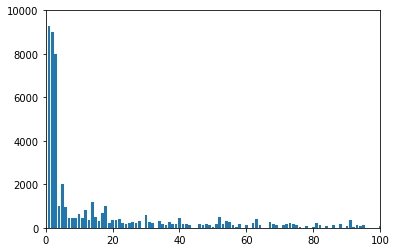

In [ ]:
import matplotlib.pyplot as plt
df1=df.select("label").groupby("label").count().orderBy(desc("count")).toPandas()
plt.xlim(0, 100)
plt.ylim(0, 10000)
plt.bar(df1["count"],df1["label"])

Nous remarquons que la distribution de la target (price) est déséquilibrer, nous lui appliquerons une tranformation log afin de mieux normaliser la distribution

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<BarContainer object of 723 artists>

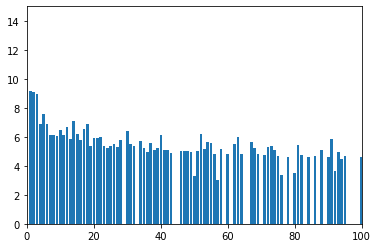

In [ ]:
import numpy as np
df1=df.select("label").groupby("label").count().orderBy(desc("count")).toPandas()
plt.xlim(0, 100)
plt.ylim(0, 15)
plt.bar(df1["count"],np.log(df1["label"]))

maintenant nous avons une distribution bien équilibrée

L'attribut neighbourhood

<BarContainer object of 20 artists>

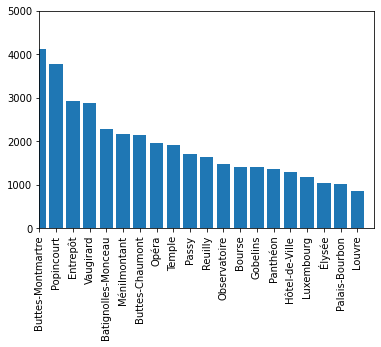

In [ ]:
df1=df.select("neighbourhood").groupby("neighbourhood").count().orderBy(desc("count")).toPandas()
plt.xlim(0, 20)
plt.ylim(0, 5000)
plt.xticks(rotation=90)
plt.bar(df1["neighbourhood"],df1["count"])

*Nous* remarquons que même l'attribut neighboorhood est déséquilibré, nous vérifions que le neighboorhood est équilibré selon les valeurs de prix.

<BarContainer object of 20 artists>

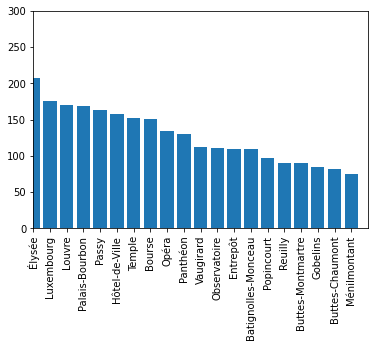

In [ ]:
from pyspark.sql.functions import mean

df1=df.groupby("neighbourhood").agg(mean("label")).orderBy(desc("avg(label)")).toPandas()

plt.xlim(0, 20)
plt.ylim(0, 300)
plt.xticks(rotation=90)
plt.bar(df1["neighbourhood"],df1["avg(label)"])

nous utiliserons la même procédure pour tous les attributs.à chaque fois, nous visualisons les valeurs des attributs en fonction du nombre d'occurrences et de la moyenne des prix.aprés on va essayé de supprimer si c'est possible les attributs non pertinante 

L'attribut room_type

represente le type de la chambre

<BarContainer object of 4 artists>

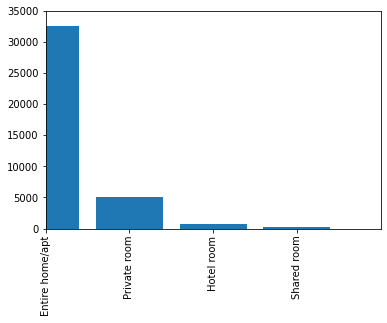

In [ ]:
df1=df.select("room_type").groupby("room_type").count().orderBy(desc("count")).toPandas()
plt.xlim(0, 4)
plt.ylim(0, 35000)
plt.xticks(rotation=90)
plt.bar(df1["room_type"],df1["count"])

<BarContainer object of 4 artists>

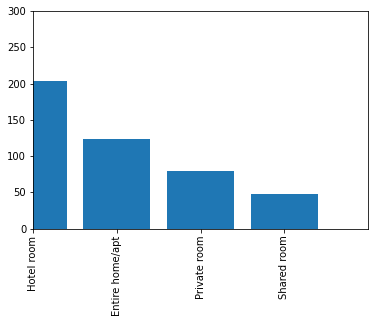

In [ ]:

df1=df.groupby("room_type").agg(mean("label")).orderBy(desc("avg(label)")).toPandas()

plt.xlim(0, 4)
plt.ylim(0, 300)
plt.xticks(rotation=90)
plt.bar(df1["room_type"],df1["avg(label)"])

L'attribut availability_365

C'est le nombre de nuits disponibles à louer pendant 1 année (365 jours)


<BarContainer object of 366 artists>

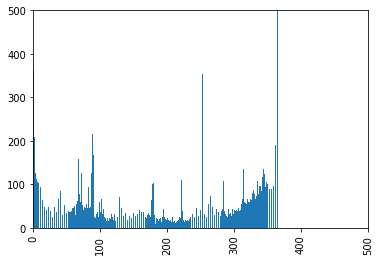

In [ ]:
df1=df.select("availability_365").groupby("availability_365").count().orderBy(desc("count")).toPandas()
plt.xlim(0, 500)
plt.ylim(0, 500)
plt.xticks(rotation=90)
plt.bar(df1["availability_365"],df1["count"])

<BarContainer object of 366 artists>

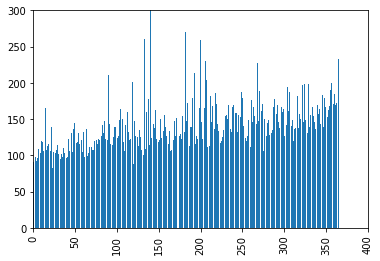

In [ ]:
df1=df.groupby("availability_365").agg(mean("label")).orderBy(desc("avg(label)")).toPandas()

plt.xlim(0, 400)
plt.ylim(0, 300)
plt.xticks(rotation=90)
plt.bar(df1["availability_365"],df1["avg(label)"])

L'attribut reviews_per_month

<BarContainer object of 741 artists>

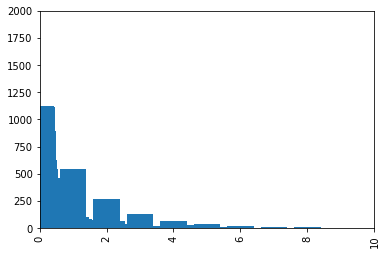

In [ ]:
df1=df.select("reviews_per_month").groupby("reviews_per_month").count().orderBy(desc("count")).toPandas()
plt.xlim(0, 10)
plt.ylim(0, 2000)
plt.xticks(rotation=90)
plt.bar(df1["reviews_per_month"],df1["count"])

<BarContainer object of 741 artists>

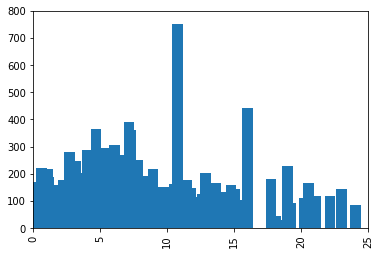

In [ ]:
df1=df.groupby("reviews_per_month").agg(mean("label")).orderBy(desc("avg(label)")).toPandas()

plt.xlim(0, 25)
plt.ylim(0, 800)
plt.xticks(rotation=90)
plt.bar(df1["reviews_per_month"],df1["avg(label)"])

L'attribut number_of_reviews_ltm

<BarContainer object of 131 artists>

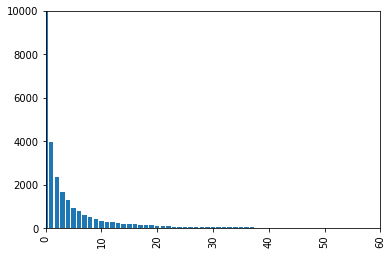

In [ ]:
df1=df.select("number_of_reviews_ltm").groupby("number_of_reviews_ltm").count().orderBy(desc("count")).toPandas()
plt.xlim(0, 60)
plt.ylim(0, 10000)
plt.xticks(rotation=90)
plt.bar(df1["number_of_reviews_ltm"],df1["count"])

<BarContainer object of 131 artists>

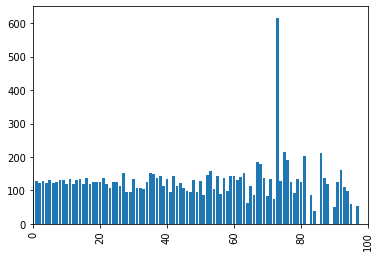

In [ ]:
df1=df.groupby("number_of_reviews_ltm").agg(mean("label")).orderBy(desc("avg(label)")).toPandas()

plt.xlim(0, 100)
plt.ylim(0, 650)
plt.xticks(rotation=90)
plt.bar(df1["number_of_reviews_ltm"],df1["avg(label)"])

In [ ]:
from pyspark.sql.functions import log
df = df.withColumn("label",log(df["label"]).cast(DoubleType()))

Nous allons essayer de voir la matrice de corrélation, pour voir les attributs corrélés.

In [ ]:
import pandas as pd
import numpy as np
d=df.toPandas()
rs = np.random.RandomState(0)
corr = d.corr()
corr.style.background_gradient(cmap='BrBG_r')
# 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps

,latitude,longitude,label,number_of_reviews,reviews_per_month,availability_365,number_of_reviews_ltm
latitude,1.000000,0.092495,-0.052535,-0.022854,-0.021811,-0.039625,-0.011252
longitude,0.092495,1.000000,-0.184011,-0.013476,-0.028523,-0.098541,-0.017738
label,-0.052535,-0.184011,1.000000,0.053601,0.081866,0.345577,0.050531
number_of_reviews,-0.022854,-0.013476,0.053601,1.000000,0.613897,0.203916,0.440921
reviews_per_month,-0.021811,-0.028523,0.081866,0.613897,1.000000,0.222965,0.633908
availability_365,-0.039625,-0.098541,0.345577,0.203916,0.222965,1.000000,0.150240
number_of_reviews_ltm,-0.011252,-0.017738,0.050531,0.440921,0.633908,0.150240,1.000000


Nous remarquons que plusieurs attributs sont corrélés les uns aux autres,par exemple, le coefficient de corrélation entre le nombre de revues et le nombre de revues par mois est élevé et c'est logique car plus il y a de revues par mois, plus le nombre de revues est elevé,on remarque également qu'il n'y a pas de corrélation entre le prix et le nombre de revues, et c'est logique car généralement on ne prend pas en compte le nombre de revenus mais le contenu de ces derniers.aussi on remarque que il y une forte corrélation entre les attributs longitude et latitude.

Pour la suite nous allons faire :

*   standarisation des données
*   utiliser le one hot encoding pour les variables catégorielles
*   Tester d'autres modéle de regression

en fin on va essayer d'utiliser PCA pour reduire la dimension et voir si cette technique améliore bien les resultats ou non 

In [ ]:
#Standatisation 

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

for i in ["latitude","longitude","number_of_reviews","reviews_per_month","availability_365","number_of_reviews_ltm"]:
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")

    pipeline = Pipeline(stages=[assembler, scaler])

    df = pipeline.fit(df).transform(df).withColumn(i+"_Scaled", unlist(i+"_Scaled")).drop(i+"_Vect")

print("After Scaling :")
df.show(5)

After Scaling :
+-----------------+--------+---------+---------------+-----+-----------------+-----------------+----------------+---------------------+---------------+----------------+------------------------+------------------------+-----------------------+----------------------------+
|    neighbourhood|latitude|longitude|      room_type|label|number_of_reviews|reviews_per_month|availability_365|number_of_reviews_ltm|latitude_Scaled|longitude_Scaled|number_of_reviews_Scaled|reviews_per_month_Scaled|availability_365_Scaled|number_of_reviews_ltm_Scaled|
+-----------------+--------+---------+---------------+-----+-----------------+-----------------+----------------+---------------------+---------------+----------------+------------------------+------------------------+-----------------------+----------------------------+
|   Hôtel-de-Ville|48.85247|  2.35835|Entire home/apt|  110|              260|             2.68|              29|                   35|          0.425|           0.553|

maintenant nous allons travailler avec les attributs normalisés, nous allons aussi essayer de travailler avec les embedding de onehotencoding

In [ ]:
my_col = df.select(['neighbourhood','latitude_Scaled','longitude_Scaled','room_type','label','number_of_reviews_Scaled','reviews_per_month_Scaled','availability_365_Scaled',"number_of_reviews_ltm_Scaled"])
df = my_col.na.drop()
df.printSchema()
df.show()

root
 |-- neighbourhood: string (nullable = true)
 |-- latitude_Scaled: double (nullable = true)
 |-- longitude_Scaled: double (nullable = true)
 |-- room_type: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- number_of_reviews_Scaled: double (nullable = true)
 |-- reviews_per_month_Scaled: double (nullable = true)
 |-- availability_365_Scaled: double (nullable = true)
 |-- number_of_reviews_ltm_Scaled: double (nullable = true)

+-------------------+---------------+----------------+---------------+-----+------------------------+------------------------+-----------------------+----------------------------+
|      neighbourhood|latitude_Scaled|longitude_Scaled|      room_type|label|number_of_reviews_Scaled|reviews_per_month_Scaled|availability_365_Scaled|number_of_reviews_ltm_Scaled|
+-------------------+---------------+----------------+---------------+-----+------------------------+------------------------+-----------------------+----------------------------+
|     Hô

In [ ]:
numericCols = [t[0] for t in df.dtypes if (t[1] == 'int' or t[1]=='double')and t[0]!="label"]
df.select(numericCols).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
latitude_Scaled,38622,0.5486431049660832,0.19542656361499805,0.0,1.0
longitude_Scaled,38622,0.5023736730360953,0.1341704380962539,0.0,1.0
number_of_reviews_Scaled,38622,0.016346331106621075,0.03104709989729747,0.0,1.0
reviews_per_month_Scaled,38622,0.015964968152864873,0.024725746994933018,0.0,1.0
availability_365_Scaled,38622,0.27679180259955344,0.3663589660765347,0.0,1.0
number_of_reviews_ltm_Scaled,38622,0.0021045259178706405,0.008274502338871913,0.0,1.0


In [ ]:
categoricalColumns = [t[0] for t in df.dtypes if t[1] == 'string']
df.select(categoricalColumns).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
neighbourhood,38622,None,None,Batignolles-Monceau,Élysée
room_type,38622,None,None,Entire home/apt,Shared room


In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

stages = []


for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]


assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features']
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: integer (nullable = true)
 |-- features: vector (nullable = true)



## Test de differents modèles :
Dans cette partie, nous avons testé plusieurs modèles dont : DecisionTreeRegressor, RandomForestRegressor, LinearRegression, GBTRegressor afin de les comparer entre eux.nous comparons également l'effets de l'utilisation de onehotencoding,Nous avons également effectuer un gridsearch et crossvalidation sur chacun des modèles

Remarque : pour des problèmes de mémoire et de temps d'exécution, nous avons limité le nombre de paramètres à optimiser.


In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 27069
Test Dataset Count: 11553


In [ ]:
train.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    8|(28,[0,20,22,23],...|
|    8|(28,[9,20,22,23],...|
|    9|(28,[0,20,22,23],...|
|   10|(28,[0,19,22,23,2...|
|   10|(28,[1,19,22,23,2...|
|   10|(28,[2,19,22,23,2...|
|   10|(28,[3,19,22,23,2...|
|   10|(28,[5,19,22,23],...|
|   10|(28,[5,22,23],[1....|
|   10|(28,[14,19,22,23,...|
|   10|(28,[15,19,22,23,...|
|   10|(28,[15,19,22,23,...|
|   10|(28,[17,19,22,23,...|
|   10|(28,[19,22,23,24,...|
|   11|(28,[10,20,22,23,...|
|   12|(28,[17,20,22,23]...|
|   13|(28,[3,20,22,23],...|
|   15|(28,[0,19,22,23,2...|
|   15|(28,[1,22,23],[1....|
|   15|(28,[1,22,23,24,2...|
+-----+--------------------+
only showing top 20 rows



### DecisionTreeRegressor

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor

dt = DecisionTreeRegressor(featuresCol="features",labelCol="label")
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.show()

+-----+--------------------+------------------+
|label|            features|        prediction|
+-----+--------------------+------------------+
|    0|(28,[3,21,22,23,2...|124.67378843147473|
|   10|(28,[4,22,23,24,2...|124.46195652173913|
|   10|(28,[6,22,23,24,2...| 77.31668526785714|
|   10|(28,[13,19,22,23,...|214.45064805583252|
|   10|(28,[15,19,22,23,...|124.67378843147473|
|   11|(28,[0,19,22,23],...| 82.20319027725029|
|   15|(28,[0,19,22,23,2...| 82.20319027725029|
|   15|(28,[4,20,22,23],...| 43.03813559322034|
|   15|(28,[13,20,22,23]...| 53.86153846153846|
|   15|(28,[14,22,23,24,...| 89.35958904109589|
|   16|(28,[5,20,22,23,2...|41.627604166666664|
|   17|(28,[0,22,23],[1....| 82.20319027725029|
|   17|(28,[18,20,22,23,...| 174.8221087767524|
|   18|(28,[0,20,22,23],...| 43.03813559322034|
|   18|(28,[1,22,23,24,2...|109.02199312714777|
|   19|(28,[5,19,22,23,2...| 77.31668526785714|
|   19|(28,[6,20,22,23],...|41.627604166666664|
|   19|(28,[11,20,22,23,...|62.664096916

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Rmse = %g" % rmse)

Rmse = 186.569


In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
rmse = evaluator.evaluate(predictions)
print("MAE = %g" % rmse)

MAE = 61.2538


Nous remarquons qu'il y a une petite amélioration par rapport aux premiers tests, le Rmse est passé de 188 a 186, cependant nous pouvons faire mieux si nous utilisons la validation croisée

on remarque aussi que l'utilisation de onehotencoding améliore les resultas

### DecisionTreeRegressor avec une cross Validation

In [ ]:
#with cross validation 

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 5, 10])
             .addGrid(dt.minInstancesPerNode, [1, 2, 3,4,5])
             .build())

cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('ROC', evaluator.evaluate(predictions))



ROC 61.25380994254437


In [ ]:
bestModel = cvModel.bestModel
predictions = bestModel.transform(test)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE = %g" % rmse)

RMSE = 186.569


Maintenant, nous allons essayer de tester d'autres modèles et ensuite nous ferons une comparaison entre les résultats

### LinearRegression

In [ ]:

from pyspark.ml.regression import LinearRegression

dt = LinearRegression(featuresCol="features",labelCol="label")
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.show()

+-----+--------------------+------------------+
|label|            features|        prediction|
+-----+--------------------+------------------+
|    0|(28,[3,21,22,23,2...|136.83549631600854|
|   10|(28,[4,22,23,24,2...| 34.99512841483151|
|   10|(28,[6,22,23,24,2...|11.392947187545289|
|   10|(28,[13,19,22,23,...|146.17078217379776|
|   10|(28,[15,19,22,23,...|140.54598813463693|
|   11|(28,[0,19,22,23],...| 88.82179157017693|
|   15|(28,[0,19,22,23,2...| 68.12247650971261|
|   15|(28,[4,20,22,23],...|52.702584042722805|
|   15|(28,[13,20,22,23]...|30.209086412005476|
|   15|(28,[14,22,23,24,...| 47.01010164830187|
|   16|(28,[5,20,22,23,2...| 36.36986657826425|
|   17|(28,[0,22,23],[1....|13.392250653946704|
|   17|(28,[18,20,22,23,...|140.87926421089483|
|   18|(28,[0,20,22,23],...| 32.91140540545679|
|   18|(28,[1,22,23,24,2...| 70.32209410157014|
|   19|(28,[5,19,22,23,2...| 65.22265812157737|
|   19|(28,[6,20,22,23],...|30.775155265898434|
|   19|(28,[11,20,22,23,...| 54.57363322

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
mse = evaluator.evaluate(predictions)
print("Rmse= %g" % mse)

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print("MAE  = %g" % mae)

Rmse= 185.593
MAE  = 59.9801


### LinearRegression avec une cross validation 

In [ ]:

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(dt.aggregationDepth, [2, 5, 10])
             .addGrid(dt.maxIter, [10, 20, 30,40,50])
             .build())

cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)

bestModel = cvModel.bestModel
predictions = bestModel.transform(test)

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE = %g" % rmse)

RMSE = 185.593


### RandomForestRegressor

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

dt = RandomForestRegressor(featuresCol="features",labelCol="label")
dtModel = dt.fit(train)
predictions = dtModel.transform(test)

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
mse = evaluator.evaluate(predictions)
print("Rmse on test data = %g" % mse)

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print("MAE on test data = %g" % mae)



Rmse on test data = 185.859
MAE on test data = 59.8942


In [ ]:
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 5, 10])
             .addGrid(dt.numTrees, [10, 20])
             .build())

cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)

bestModel = cvModel.bestModel
predictions = bestModel.transform(test)


evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE = %g" % rmse)

RMSE = 186.683


### GBTRegressor

In [ ]:
#with GBTRegressor

from pyspark.ml.regression import GBTRegressor

dt = GBTRegressor(featuresCol="features",labelCol="label")
dtModel = dt.fit(train)
predictions = dtModel.transform(test)

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
print("Rmse on test data = %g" % mse)

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
mae = evaluator.evaluate(predictions)
print("MAE on test data = %g" % mae)


Rmse on test data = 35648.8
MAE on test data = 60.0558


In [ ]:
paramGrid = (ParamGridBuilder()
             .addGrid(dt.maxDepth, [2, 5, 10])
             .addGrid(dt.maxIter, [20, 30,40,50])
             .build())

cv = CrossValidator(estimator=dt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)

bestModel = cvModel.bestModel
predictions = bestModel.transform(test)


evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE = %g" % rmse)

RMSE = 185.099


Comparaison des modéles : 

on remarque que les quatre modèles testés donnent de meilleurs résultats, car un Rmse égal à 186 signifie que "l'erreur moyenne entre le prix du loyer et le prix prédit est de 186 euros, d'autre part on remarque que RandomForestRegressor est le modèle le plus performant, et que le GBTRegressor donne de mauvais résultats.

Pour la suite nous allons faire :

*   Réduction de dimension avec PCA 

au lieu de travailler avec toutes les dimensions nous allons essayer de réduire la dimension (pour notre cas nous avons choisi 3 dimensions)

In [ ]:
#PCA 

from pyspark.ml.feature import PCA
from pyspark.mllib.linalg import Vectors

pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df)
result = model.transform(df).select("label","pcaFeatures")
result.show(truncate=False)

+-----+---------------------------------------------------------------+
|label|pcaFeatures                                                    |
+-----+---------------------------------------------------------------+
|110  |[-52.136214634341435,-258.8187300730929,3.707318811398679]     |
|100  |[-280.38490512803276,-253.43647409246978,-25.549217707644978]  |
|130  |[-347.1979095249528,24.727732888350346,-2.657489962886703]     |
|80   |[-200.0176922816017,-13.911579636155015,1.1491449861229963]    |
|80   |[-257.18713888881814,-25.187821609831346,-6.169870032867978]   |
|75   |[-363.1680625926599,13.98177766945149,-2.2251357231995232]     |
|143  |[-73.91463377208967,-18.396218118627306,-3.365035840427375]    |
|170  |[-175.55763434635278,-135.46972376338175,-14.889693144041207]  |
|100  |[-253.39504578408403,6.490844286379374,-3.3406723565750442]    |
|60   |[-126.88797605599503,6.995079032081518,0.820116922397294]      |
|110  |[-334.17967366400336,-55.207195968705165,-11.912922296154

In [ ]:
train, test = result.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 27069
Test Dataset Count: 11553


In [ ]:
dt = DecisionTreeRegressor(featuresCol="pcaFeatures",labelCol="label")
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.show()

+-----+--------------------+------------------+
|label|         pcaFeatures|        prediction|
+-----+--------------------+------------------+
|    0|[-0.9697661334256...| 87.78927911275416|
|   10|[-1.7574485367320...|   87.008126341613|
|   10|[-0.7886900767451...|   87.008126341613|
|   10|[-0.3516097553176...|   87.008126341613|
|   10|[-0.1202355396659...| 95.79714912280701|
|   11|[-1.5427740533138...|   87.008126341613|
|   15|[-131.70749574763...|173.79775280898878|
|   15|[-0.1736301190031...| 77.22533495736906|
|   15|[-0.1130019533913...| 95.79714912280701|
|   15|[-0.1072126756862...| 95.79714912280701|
|   16|[-0.2933120357144...|   87.008126341613|
|   17|[-1.0750571010062...|   87.008126341613|
|   17|[-0.0876735044176...| 77.22533495736906|
|   18|[-343.89354687519...|167.14669926650367|
|   18|[-312.99919025167...|144.90459670424977|
|   19|[-89.798142937178...|173.79775280898878|
|   19|[-1.1631607800611...|   87.008126341613|
|   19|[-0.4193221615088...|   87.008126

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("RMSE= %g" % rmse)

RMSE= 188.465


nous remarquons que la réduction de la dimension n'améliore pas beaucoup les résultats

# Test sur les données de bank (classification supervisé)

Ici on va travailler avec des données de bank,L'ensemble de données nous donne des informations sur une campagne de marketing d'une institution financière que nous devons analyser afin de trouver la meilleure stratégie de marketing

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('bank.csv', header = True, inferSchema = True)
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



Avant de commencer, nous vérifions que les targets sont bien équilibrées 

In [ ]:
df.groupby('deposit').count().show()

+-------+-----+
|deposit|count|
+-------+-----+
|     no| 5873|
|    yes| 5289|
+-------+-----+



puis nous récupérerons les données numériques et catégorielles 

In [ ]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


In [ ]:
catégorial_features = [t[0] for t in df.dtypes if t[1] == 'string']
df.select(catégorial_features).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
job,11162,None,None,admin.,unknown
marital,11162,None,None,divorced,single
education,11162,None,None,primary,unknown
default,11162,None,None,no,yes
housing,11162,None,None,no,yes
loan,11162,None,None,no,yes
contact,11162,None,None,cellular,unknown
month,11162,None,None,apr,sep
poutcome,11162,None,None,failure,unknown


nous remarquons que les attributs day et months ne sont pas utiles pour la clasification, nous allons donc supprimer ces attributs

In [ ]:
#day and month not useful so we delete it 
df = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



Encodage des features: indexation des string, assemblage des vecteurs puis indexation

In [ ]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



On découpe notre dataset en train (70%) et test (30%)

In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


aprés on va utiliser une regression logistique pour faire la classification

In [ ]:
#Logistic Regression Model
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train)

predictions = lrModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 33|management|  0.0|[1.93084854518128...|       0.0|[0.87334331124860...|
| 49|management|  0.0|[1.92783695472097...|       0.0|[0.87300981013433...|
| 52|management|  0.0|[-0.7737627890181...|       1.0|[0.31566570209267...|
| 53|management|  0.0|[0.94708137344074...|       0.0|[0.72052784002179...|
| 58|management|  0.0|[2.44657764692457...|       0.0|[0.92031082026376...|
| 32|management|  0.0|[1.28386077546037...|       0.0|[0.78310624913886...|
| 57|management|  0.0|[1.05745870556531...|       0.0|[0.74220460119091...|
| 52|management|  0.0|[3.25200815517462...|       0.0|[0.96274520587479...|
| 46|management|  0.0|[2.24978402804239...|       0.0|[0.90463190417562...|
| 31|management|  0.0|[1.47121751117284...|       0.0|[0.81324237120150...|
+---+-------

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print('ROC', evaluator.evaluate(predictions))

ROC 0.885643189559481


In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics

valuesAndPreds = predictions.select(['label', 'prediction'])
# It needs to convert to RDD as the parameter of RegressionMetrics
valuesAndPreds = valuesAndPreds.rdd.map(tuple)


metrics = RegressionMetrics(valuesAndPreds)

# Squared Error
print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)

# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


MSE = 0.20290293317205926
RMSE = 0.4504474810364237
MAE = 0.20290293317205926


avec un MSE=0.2 qui représente la moyenne des carrés des erreurs, nous pouvons dire que notre modèle donne de très bons résultats

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


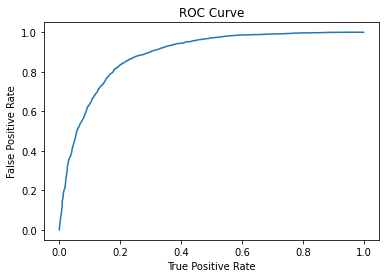

Training set areaUnderROC: 0.8877385690600346


In [ ]:
import matplotlib.pyplot as plt

trainingSummary = lrModel.summary

roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


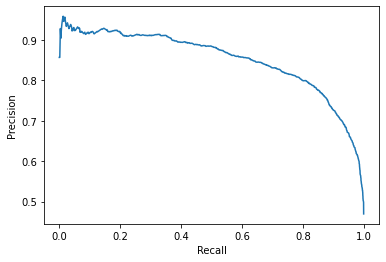

In [ ]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


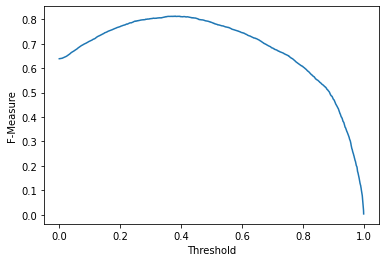

In [ ]:
f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.show()

Nous allons maintenant essayer d'utiliser une validation croisée pour trouver les paramètres optimaux.

In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train)
predictions = cvModel.transform(test)
print('ROC', evaluator.evaluate(predictions))

ROC 0.8844768025913865


In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics

valuesAndPreds = predictions.select(['label', 'prediction'])
# It needs to convert to RDD as the parameter of RegressionMetrics
valuesAndPreds = valuesAndPreds.rdd.map(tuple)


metrics = RegressionMetrics(valuesAndPreds)

# Squared Error
print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)

# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


MSE = 0.20592682189295433
RMSE = 0.45379160623898096
MAE = 0.20592682189295433


maintenant on va tester une arbre de decsion pour faire la classification

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------+----------+--------------------+
|age|       job|label| rawPrediction|prediction|         probability|
+---+----------+-----+--------------+----------+--------------------+
| 33|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 49|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[520.0,1931.0]|       1.0|[0.21215830273357...|
| 53|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 58|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 32|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 57|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 52|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 46|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
| 31|management|  0.0|[2498.0,481.0]|       0.0|[0.83853642161799...|
+---+----------+-----+--------------+----------+--------------------+
only showing top 10 

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.7808118726917547


In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics

valuesAndPreds = predictions.select(['label', 'prediction'])
valuesAndPreds = valuesAndPreds.rdd.map(tuple)


metrics = RegressionMetrics(valuesAndPreds)

# Squared Error
print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)

# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


MSE = 0.22860598729966738
RMSE = 0.4781275847508355
MAE = 0.22860598729966738


Nous remarquons que la régression logistique est plus performante que l'arbre de décision, car dans la régression nous trouvons une mse égale à 0.201 alors que dans l'arbre de décision nous trouvons une mse égale à 0.22

Nous essayons maintenant de trouver les paramètres optimaux en utilisant la validation croisée, puis nous testons le meilleur modèle.

In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(dt.maxDepth, [4, 5, 6, 7]) \
    .addGrid(dt.maxBins, [24, 28, 32, 36]) \
    .build()

In [ ]:
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)  

In [ ]:
cvModel = crossval.fit(train)
predictions = cvModel.transform(test)
print('ROC', evaluator.evaluate(predictions))

ROC 0.7972721701387365


In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics

valuesAndPreds = predictions.select(['label', 'prediction'])
# It needs to convert to RDD as the parameter of RegressionMetrics
valuesAndPreds = valuesAndPreds.rdd.map(tuple)


metrics = RegressionMetrics(valuesAndPreds)

# Squared Error
print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)

# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


MSE = 0.20471726640459634
RMSE = 0.45245692215347566
MAE = 0.2047172664045963


Maintenant nous essayons de ne pas utiliser le onehotEncoder, nous décodons les données catégorielles juste avec StringIndexer

In [ ]:

stages = []

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    stages += [stringIndexer]

label_stringIdx = StringIndexer(inputCol = 'deposit', outputCol = 'label')
stages += [label_stringIdx]

numericCols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
assemblerInputs = [c + "Index" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [ ]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)
df = pipelineModel.transform(df)
selectedCols = ['label', 'features'] + cols
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7855
Test Dataset Count: 3307


In [ ]:
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train)
predictions = dtModel.transform(test)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+-------------+-----+--------------+----------+--------------------+
|age|          job|label| rawPrediction|prediction|         probability|
+---+-------------+-----+--------------+----------+--------------------+
| 38|  blue-collar|  0.0|[820.0,1224.0]|       1.0|[0.40117416829745...|
| 31| entrepreneur|  0.0|[2077.0,292.0]|       0.0|[0.87674124102997...|
| 38|  blue-collar|  0.0|[2077.0,292.0]|       0.0|[0.87674124102997...|
| 48|  blue-collar|  0.0|  [380.0,31.0]|       0.0|[0.92457420924574...|
| 48|self-employed|  0.0|[435.0,1775.0]|       1.0|[0.19683257918552...|
| 36|   unemployed|  0.0|[820.0,1224.0]|       1.0|[0.40117416829745...|
| 29|  blue-collar|  0.0|[2077.0,292.0]|       0.0|[0.87674124102997...|
| 45|  blue-collar|  0.0|[2077.0,292.0]|       0.0|[0.87674124102997...|
| 50|  blue-collar|  0.0|[435.0,1775.0]|       1.0|[0.19683257918552...|
| 25|   technician|  0.0|[820.0,1224.0]|       1.0|[0.40117416829745...|
+---+-------------+-----+--------------+----------+

In [ ]:
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.781052215769142


In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics

valuesAndPreds = predictions.select(['label', 'prediction'])
# It needs to convert to RDD as the parameter of RegressionMetrics
valuesAndPreds = valuesAndPreds.rdd.map(tuple)


metrics = RegressionMetrics(valuesAndPreds)

# Squared Error
print("MSE = %s" % metrics.meanSquaredError)
print("RMSE = %s" % metrics.rootMeanSquaredError)

# Mean absolute error
print("MAE = %s" % metrics.meanAbsoluteError)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


MSE = 0.2255820985787723
RMSE = 0.474954838462324
MAE = 0.2255820985787723


Nous remarquons que le onehotencoder permet d'augmenter les performances de notre modéles